# Policy Gradient --- Practical Session

In [2]:
import gym
import jax
import jax.numpy as jnp
import jax.random as random
from jax import grad
jax.config.update('jax_platform_name', 'cpu')
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'gym'

### (quick intro to gym = super quick MDP revision)

In [3]:
env = gym.make("CartPole-v1")
n_actions = env.action_space.n
state_dim = env.observation_space.shape[0]

NameError: name 'gym' is not defined

### Interaction loop (code is given)

In [3]:
def run_interaction(env, agent, n_steps=10**5, discount=0.99, seed=None, render=False):
    performance = 0.
    performances = []
    state = env.reset(seed=seed)
    last_reset = 0
    
    for t in range(n_steps):
        action = agent.act(state)
        
        next_state, reward, done, _ = env.step(action)
        discounted_reward = reward * discount**(t - last_reset)
        performance += discounted_reward
        
        if render:
            env.render()
            
        agent.update(state, action, reward, next_state, done)
        
        if done:
            print('Performance: %.2f' % performance)
            performances.append(performance)
            performance = 0
            state = env.reset()
            last_reset = t + 1
        else:
            state = next_state
        
    env.close()
    return performances

### jax quickstart: arrays, random numbers
Give links to useful functions

### Base (uniform) policy

In [4]:
class Policy:
    def __init__(self, state_dim, n_actions, seed=0):
        self.state_dim = state_dim
        self.n_actions = n_actions
        self.reset(seed=seed)
    
    def reset(self, seed=0):
        self.param = None

    def probs_func(self, state, param):
        return jnp.ones(self.n_actions) / self.n_actions
    
    def probs(self, state):
        return self.probs_func(state, self.param)
    
    def get_param(self):
        return self.param
    
    def set_param(self, param):
        self.param = param

### Simple non-adaptive agent

In [17]:
class Agent:
    def __init__(self, policy, seed=0):
        self.policy = policy
        self.reset(seed=seed)
    
    def reset(self, seed=0):
        self.key = random.PRNGKey(seed)    
    
    def act(self, state):
        self.key, subkey = random.split(self.key)
        probs = self.policy.probs(state)
        action = random.choice(subkey, len(probs), p=probs).item()
        return action
    
    def update(self, state, action, discounted_reward, next_state, done):
        pass

### Run the uniform policy

In [18]:
uniform_policy = Policy(state_dim, n_actions)
random_agent = Agent(uniform_policy)

In [19]:
run_interaction(env, random_agent, n_steps=100, render=False)

Performance: 33.10
Performance: 19.84
Performance: 13.13
Performance: 16.55


[33.10282414303193, 19.836941046095397, 13.12541872310217, 16.548623854991238]

### Policy Gradient (revision)

### Exercise 1: implement linear-Softmax policy

In [1]:
class LinearSoftmaxPolicy(Policy):
    def __init__(self, state_dim, n_actions, temperature=1.):
        super().__init__(state_dim, n_actions)
        self.temperature = temperature
    
    def reset(self, seed=0):
        self.param = jnp.zeros((self.n_actions, self.state_dim))
    
    def probs_func(self, state, param):
        #solution
        state_features = jnp.array(state)
        log_probs = self.temperature * jnp.dot(param, state_features)
        offset = jnp.max(log_probs)
        exponential_weights = jnp.exp(log_probs - offset)
        normalization = jnp.sum(exponential_weights)
        return exponential_weights / normalization
        #end solution

NameError: name 'Policy' is not defined

In [21]:
uniform_policy = LinearSoftmaxPolicy(state_dim, n_actions)
random_agent = Agent(uniform_policy)
run_interaction(env, random_agent, n_steps=100, render=False)

Performance: 25.28
Performance: 10.47
Performance: 23.00
Performance: 28.23


[25.28279056684035, 10.466174574128356, 22.995685419484463, 28.226946740172476]

### jax quickstart: grad

### Exercise 2: implement actor-only policy gradient

In [9]:
class ActorOnly(Agent):
    def __init__(self, policy, discount=0.99, lr=1e-3):
        super().__init__(policy)
        self.discount = discount
        self.lr = lr
        
    def reset(self, seed=0):
        super().reset(seed=seed)
        #solution
        self.rewards = []
        self.scores = []
        #end solution
    
    def update(self, state, action, reward, next_state, done):
        #solution
        self.rewards.append(reward)
        
        current_param = self.policy.get_param()
        
        def logpi(param):
            return jnp.log(self.policy.probs_func(state, param)[action])
        
        score_fun = grad(logpi)
        score = score_fun(current_param)
        self.scores.append(score)
        
        if done:
            horizon = len(self.rewards)
            discounts = jnp.ones(horizon) * self.discount
            discounts = discounts.at[0].set(1.)
            discounts = jnp.cumprod(discounts)
            discounted_rewards = jnp.array(self.rewards) * discounts
            returns_to_go = jnp.cumsum(discounted_rewards[::-1])[::-1]
            policy_gradient = jnp.dot(jnp.array(self.scores).T, returns_to_go).T
            new_param = current_param + self.lr * policy_gradient
            self.policy.set_param(new_param)
            self.rewards = []
            self.scores = []
        #end solution

In [10]:
pol = LinearSoftmaxPolicy(state_dim, n_actions)
softmax_agent = ActorOnly(pol, lr=1e-3)

In [11]:
pf = run_interaction(env, softmax_agent, n_steps=10000, render=False)

Performance: 37.02
Performance: 22.22
Performance: 11.36
Performance: 13.13
Performance: 24.53
Performance: 13.99
Performance: 16.55
Performance: 18.21
Performance: 8.65
Performance: 26.03
Performance: 19.84
Performance: 25.28
Performance: 45.28
Performance: 29.66
Performance: 25.28
Performance: 12.25
Performance: 11.36
Performance: 36.38
Performance: 22.22
Performance: 48.49
Performance: 11.36
Performance: 17.38
Performance: 34.43
Performance: 17.38
Performance: 11.36
Performance: 19.84
Performance: 14.85
Performance: 13.99
Performance: 13.99
Performance: 31.06
Performance: 13.99
Performance: 32.43
Performance: 13.99
Performance: 26.77
Performance: 17.38
Performance: 12.25
Performance: 38.27
Performance: 22.22
Performance: 27.50
Performance: 10.47
Performance: 28.94
Performance: 23.77
Performance: 35.74
Performance: 18.21
Performance: 33.77
Performance: 49.00
Performance: 37.02
Performance: 39.50
Performance: 17.38
Performance: 25.28
Performance: 66.56
Performance: 24.53
Performance: 

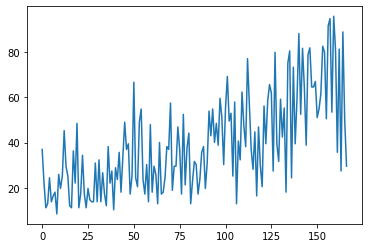

In [12]:
plt.plot(pf)

### Exercise 4 (intermediate): implement a critic

### Exercise 3 (advanced): go deep?

In [75]:
from jax.example_libraries import stax

class MLPSoftmaxPolicy(LinearSoftmaxPolicy):
    def __init__(self, state_dim, n_actions, temperature=1., hidden=8):
        self.nn_init, self.model = stax.serial(
            stax.Dense(hidden),
            stax.Tanh,
            stax.Dense(n_actions)
        )
        super().__init__(state_dim, n_actions, temperature)
        
    def reset(self, seed=0):
        key = random.PRNGKey(seed)
        output_shape, params_init = self.nn_init(key, (-1, self.state_dim))
        self.param = params_init
    
    def probs_func(self, state, param):
        #solution
        x = jnp.array(state)
        log_probs = self.temperature * self.model(self.param, x)
        offset = jnp.max(log_probs)
        exponential_weights = jnp.exp(log_probs - offset)
        normalization = jnp.sum(exponential_weights)
        return exponential_weights / normalization
        #end solution

In [76]:
mlp_policy = MLPSoftmaxPolicy(state_dim, n_actions)
random_agent = Agent(mlp_policy)
run_interaction(env, random_agent, n_steps=100, render=False)

Performance: 7.73
Performance: 24.53
Performance: 8.65
Performance: 9.56
Performance: 13.99
Performance: 10.47
Performance: 13.13


[7.72553055720799,
 24.52807127963672,
 8.64827525163591,
 9.561792499119552,
 13.994164535871148,
 10.466174574128356,
 13.12541872310217]